# Visual Transformer with Linformer

Training Visual Transformer on *Dogs vs Cats Data*

* Dogs vs. Cats Redux: Kernels Edition - https://www.kaggle.com/c/dogs-vs-cats-redux-kernels-edition
* Base Code - https://www.kaggle.com/reukki/pytorch-cnn-tutorial-with-cats-and-dogs/
* Efficient Attention Implementation - https://github.com/lucidrains/vit-pytorch#efficient-attention

In [1]:
!pip -q install vit_pytorch linformer

## Import Libraries

In [5]:
from __future__ import print_function

import glob
from itertools import chain
import os
import random
import zipfile

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from linformer import Linformer
from PIL import Image
from sklearn.model_selection import train_test_split
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms
from tqdm.notebook import tqdm

from vit_pytorch.efficient import ViT


In [2]:
print(f"Torch: {torch.__version__}")

Torch: 2.6.0.dev20241211+cu126


In [ ]:
# Training settings
batch_size = 64
epochs = 10 # 训练轮次
lr = 3e-5
gamma = 0.7
seed = 42 # 固定随机数

In [4]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_everything(seed)

In [9]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

Using device: cuda


## Load Data

In [7]:
os.makedirs('data', exist_ok=True)

In [12]:
train_dir = r'data\train'
test_dir = r'data\test'

In [9]:
# with zipfile.ZipFile('train.zip') as train_zip:
#     train_zip.extractall('data')
    
# with zipfile.ZipFile('test.zip') as test_zip:
#     test_zip.extractall('data')

In [13]:
train_list = glob.glob(os.path.join(train_dir,'*.jpg'))
test_list = glob.glob(os.path.join(test_dir, '*.jpg'))

In [17]:
print(f"Train Data: {len(train_list)}, data type: {type(train_list)}, data[0]: {train_list[0]}")
print(f"Test Data: {len(test_list)} , data type: {type(test_list)}")

Train Data: 25000, data type: <class 'list'>, data[0]: data\train\cat.0.jpg
Test Data: 12500 , data type: <class 'list'>


In [16]:
labels = [path.split('\\')[-1].split('.')[0] for path in train_list]

## Random Plots

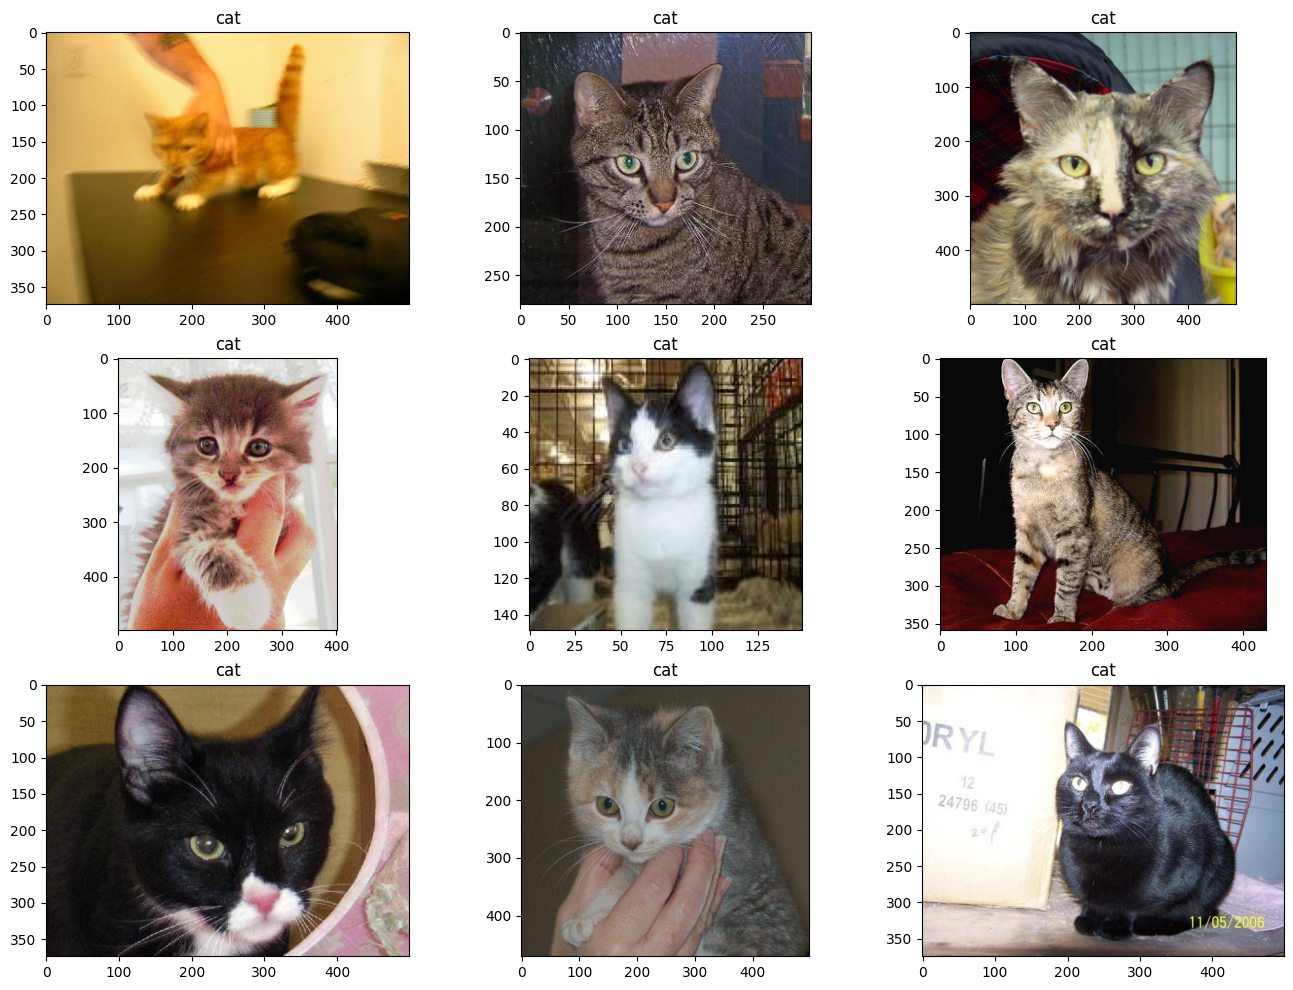

In [18]:
random_idx = np.random.randint(1, len(train_list), size=9)
# fig：整个画布对象（可用于设置标题、保存图片等）。
# axes：子图对象的数组（3×3 的二维数组），每个元素对应一个子图。
fig, axes = plt.subplots(3, 3, figsize=(16, 12))

# axes.ravel()：将二维的axes数组（3×3）展平为一维数组（共 9 个元素），便于用一个循环遍历所有子图。
# enumerate(...)：同时获取每个子图的索引（idx，0 到 8）和子图对象（ax）。
for idx, ax in enumerate(axes.ravel()):
    img = Image.open(train_list[idx])
    ax.set_title(labels[idx])
    ax.imshow(img)


## Split

In [19]:
train_list, valid_list = train_test_split(train_list, 
                                          test_size=0.2,
                                          stratify=labels,
                                          random_state=seed)

In [20]:
print(f"Train Data: {len(train_list)}")
print(f"Validation Data: {len(valid_list)}")
print(f"Test Data: {len(test_list)}")

Train Data: 20000
Validation Data: 5000
Test Data: 12500


## Image Augmentation

In [21]:
train_transforms = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.RandomResizedCrop(224), # 随机裁剪为224×224（数据增强）
        transforms.RandomHorizontalFlip(), # 随机水平翻转（数据增强）
        transforms.ToTensor(), # 转换为Tensor格式，进行归一化
    ]
)

val_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


test_transforms = transforms.Compose(
    [
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
    ]
)


## Load Datasets

In [22]:
class CatsDogsDataset(Dataset):
    def __init__(self, file_list, transform=None):
        self.file_list = file_list
        self.transform = transform

    def __len__(self):
        self.filelength = len(self.file_list)
        return self.filelength

    def __getitem__(self, idx):
        img_path = self.file_list[idx]
        img = Image.open(img_path)
        img_transformed = self.transform(img)

        label = img_path.split("\\")[-1].split(".")[0]
        label = 1 if label == "dog" else 0

        return img_transformed, label


In [23]:
train_data = CatsDogsDataset(train_list, transform=train_transforms)
valid_data = CatsDogsDataset(valid_list, transform=test_transforms)
test_data = CatsDogsDataset(test_list, transform=test_transforms)

In [24]:
train_loader = DataLoader(dataset = train_data, batch_size=batch_size, shuffle=True )
valid_loader = DataLoader(dataset = valid_data, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset = test_data, batch_size=batch_size, shuffle=True)

In [ ]:
print(len(train_data), len(train_loader)) # 20000/64=312.5

20000 313


In [26]:
print(len(valid_data), len(valid_loader))

5000 79


## Efficient Attention

### Linformer

In [ ]:
efficient_transformer = Linformer(
    dim=128,
    # 公式：seq_len = (image_size // patch_size)² + 1
    seq_len=49+1,  # 序列长度（7×7 个图像 patch + 1 个分类 token）
    depth=12, # 编码器的深度（Transformer 的层数）
    heads=8,
    k=64 # 表示k/v的投影维度
)

### Visual Transformer

In [10]:
model = ViT(
    dim=128,               # 1. 特征维度 与 Linformer 保持一致（必须匹配）
    image_size=224,        # 2. 输入图像尺寸
    patch_size=32,         # 3. 图像补丁大小：较大 patch，减少序列长度，适合轻量级任务
    num_classes=2,         # 4. 分类类别数：二分类任务
    transformer=efficient_transformer,  # 5. 自定义Transformer编码器
    channels=3,            # 6. 输入图像通道数
).to(device)              # 7. 加载到计算设备

### Training

In [ ]:
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer：根据损失函数的梯度，更新模型参数以最小化损失。
optimizer = optim.Adam(model.parameters(), lr=lr)
# scheduler：在训练过程中动态调整学习率，帮助模型更好收敛。
scheduler = StepLR(optimizer, step_size=1, gamma=gamma)

In [40]:
for imgs, labels in train_loader:
    print(f"Data shape: {imgs.shape}, Label shape: {labels.shape}")
    break

Data shape: torch.Size([64, 3, 224, 224]), Label shape: torch.Size([64])


In [ ]:
import torch

# 训练过程
for epoch in range(epochs):
    epoch_loss = 0
    epoch_accuracy = 0

    for data, label in train_loader:
        data = data.to(device)
        label = label.to(device)

        output = model(data)
        loss = criterion(output, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # 直接返回最大值索引，在计算平均值
        acc = (output.argmax(dim=1) == label).float().mean()
        epoch_accuracy += acc / len(train_loader) # 计算所有批次的平均准确率和
        epoch_loss += loss / len(train_loader)

    # 验证过程
    with torch.no_grad():
        epoch_val_accuracy = 0
        epoch_val_loss = 0
        for data, label in valid_loader:
            data = data.to(device)
            label = label.to(device)

            val_output = model(data)
            val_loss = criterion(val_output, label)

            acc = (val_output.argmax(dim=1) == label).float().mean()
            epoch_val_accuracy += acc / len(valid_loader)
            epoch_val_loss += val_loss / len(valid_loader)

    # 打印当前轮次的结果
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss:.4f} - acc: {epoch_accuracy:.4f} - val_loss : {epoch_val_loss:.4f} - val_acc: {epoch_val_accuracy:.4f}\n"
    )

    # 保存模型权重
    torch.save(model.state_dict(), f'model_epoch_{epoch+1}.pth')

Epoch : 1 - loss : 0.6925 - acc: 0.5216 - val_loss : 0.6827 - val_acc: 0.5619

Epoch : 2 - loss : 0.6829 - acc: 0.5509 - val_loss : 0.6637 - val_acc: 0.5902

Epoch : 3 - loss : 0.6714 - acc: 0.5712 - val_loss : 0.6500 - val_acc: 0.6149

Epoch : 4 - loss : 0.6635 - acc: 0.5843 - val_loss : 0.6410 - val_acc: 0.6157

Epoch : 5 - loss : 0.6550 - acc: 0.5982 - val_loss : 0.6342 - val_acc: 0.6280



In [ ]:
# 加载预训练模型
checkpoint_path = 'model_epoch_5.pth'
model.load_state_dict(torch.load(checkpoint_path))
model.to(device)
print(f"已加载模型: {checkpoint_path}")

# 训练循环
for epoch in range(5, 5+epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    # 使用 tqdm 显示进度条
    for imgs, labels in train_loader:
        imgs, labels = imgs.to(device), labels.to(device)
        
        # 前向传播
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        
        # 反向传播和优化
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # 直接返回最大值索引，在计算平均值
        acc = (outputs.argmax(dim=1) == labels).float().mean()
        epoch_accuracy += acc # 计算所有批次的平均准确率和
        epoch_loss += loss
        
    # 更新进度条信息
    print(
        f"Epoch : {epoch+1} - loss : {epoch_loss/len(train_loader):.4f}"
            +f" - acc: {epoch_accuracy /len(train_loader):.4f}\n"
    )
    
    # 每个 epoch 结束后保存模型
    save_path = f'model_epoch_{epoch+1}.pth'
    torch.save(model.state_dict(), save_path)
    print(f"模型已保存至: {save_path}")
    
    # 学习率调度（可选）
    if scheduler:
        scheduler.step()

已加载模型: model_epoch_5.pth
Epoch : 6 - loss : 0.0048 - acc: 0.7776

模型已保存至: model_epoch_6.pth
Epoch : 7 - loss : 0.0068 - acc: 1.3884

模型已保存至: model_epoch_7.pth
Epoch : 8 - loss : 0.0089 - acc: 2.0054

模型已保存至: model_epoch_8.pth
Epoch : 9 - loss : 0.0109 - acc: 2.6314

模型已保存至: model_epoch_9.pth
Epoch : 10 - loss : 0.0129 - acc: 3.2584

模型已保存至: model_epoch_10.pth


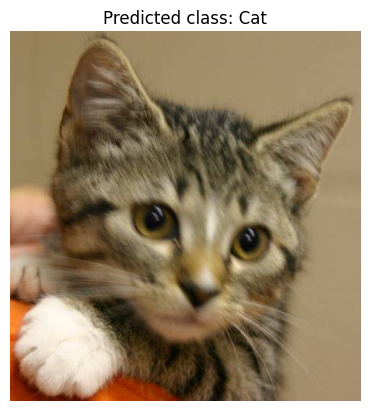

In [14]:
# 加载模型进行推理单张图片
model.load_state_dict(torch.load('model_epoch_10.pth'))  # 替换 X 为要加载的轮次
model.eval()  # 设置模型为评估模式

# 定义图像预处理步骤
transform = transforms.Compose(
    [
        transforms.Resize(256), # 缩放
        transforms.CenterCrop(224), # 中心裁剪为224×224
        transforms.ToTensor(),
    ]
)

# 加载单张图片进行推理
def predict_image(image_path):
    image = Image.open(image_path).convert('RGB')  # 打开并转换为RGB模式
    image = transform(image).unsqueeze(0)  # 预处理并增加一个批次维度
    image = image.to(device)  # 移动到指定设备

    with torch.no_grad():
        output = model(image)  # 进行推理
        prediction = output.argmax(dim=1)  # 获取预测结果
        return prediction.item()  # 返回预测类别

# 示例：对单张图片进行推理
image_path = r'data\test\156.jpg'  # 替换为你的图片路径
predicted_class = predict_image(image_path)

# 可视化结果
# 显示图像和预测结果
image = Image.open(image_path)
plt.imshow(image)
plt.title('Predicted class: ' + ('Cat' if predicted_class == 0 else 'Dog'))  # 0为猫，1为狗
plt.axis('off')  # 关闭坐标轴
plt.show()